In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv(r'C:\Hackathons\AV_WNS\train_LZdllcl.csv')

In [3]:
data.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


In [4]:
data.info()
print('\nColumns with NaN values are: \n')
data.isna().sum()[data.isna().sum() != 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB

Columns with NaN values are: 



education               2409
previous_year_rating    4124
dtype: int64

`education` and `previous_year_rating` have `NaN` values. We will have to deal with these before modeling. Let's also convert the data types of some of these `Series` objects.

In [5]:
## `employee_id` is actually a string, so let's convert it.
data['employee_id'] = data['employee_id'].astype('object')

In [6]:
print(data['department'].unique())
## Don't seem to be many departments, so we can improve pandas performance by changing object type to `category`
data['department'] = data['department'].astype('category')
data['region'] = data['region'].astype('category')
data['recruitment_channel'] = data['recruitment_channel'].astype('category')

['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']


In [7]:
print(data['education'].value_counts())
data['education'].fillna('Unknown', inplace = True)
data['education'] = data['education'].astype('category')

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64


In [8]:
## `gender` column: 
## Let's convert this to a one hot encoded binary variable called `F`, which equals 1 if employee is Female, else 0

data['F'] = np.where(data['gender'] == 'f', 1, 0)
data = data.drop(columns = ['gender'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null object
department              54808 non-null category
region                  54808 non-null category
education               54808 non-null category
recruitment_channel     54808 non-null category
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
F                       54808 non-null int32
dtypes: category(4), float64(1), int32(1), int64(7), object(1)
memory usage: 4.2+ MB


In [10]:
print('Number of unique ratings are:',data['previous_year_rating'].nunique())

Number of unique ratings are: 5


There seem to be about 4000 missing values in the `previous_year_rating` column. Let's see if there is a pattern in the `NaN`s.
We can groupby the different categorical variables we have and look for the percent of `NaN` in each group.

Hypothesis: The `NaN` in `previous_year_rating` could be occuring because they have only served for a year (`length_of_service` = 1). If this is true, the following query should return very few or no records.

In [11]:
data[(data['previous_year_rating'].isna()) & (data['length_of_service'] != 1)]

,employee_id,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,F


Yep. Let's just address this by assigning the department average rating to each employee.

In [12]:
dept_groups = data.groupby('department')['previous_year_rating'].mean().to_frame()
data = data.merge(dept_groups, left_on = 'department', right_on = dept_groups.index, how = 'left')
data['previous_year_rating'] = np.where(data['previous_year_rating_x'].isnull(), data['previous_year_rating_y'], data['previous_year_rating_x'])

In [13]:
data = data.drop(columns = ['previous_year_rating_x', 'previous_year_rating_y'])

In [14]:
data = data[['employee_id', 'department', 'region', 'education', 'recruitment_channel', 'no_of_trainings', 'age', 'F',
         'length_of_service', 'previous_year_rating', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted']]
data.set_index('employee_id', inplace = True)

In [15]:
data.head(3)

,department,region,education,recruitment_channel,no_of_trainings,age,F,length_of_service,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,sourcing,1,35,1,8,5.0,1,0,49,0
65141,Operations,region_22,Bachelor's,other,1,30,0,4,5.0,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,sourcing,1,34,0,7,3.0,0,0,50,0


In [16]:
data.isnull().sum()
## No NaN values, let's explore!

department              0
region                  0
education               0
recruitment_channel     0
no_of_trainings         0
age                     0
F                       0
length_of_service       0
previous_year_rating    0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

## EDA

#1. <u>Effect of `avg_training_score`</u>

In [17]:
## How does `avg_training_score` during the training period impact the target (`is_promoted`)?
ats = data.groupby('is_promoted')['avg_training_score'].mean()
ats = ats.to_frame()
ats

,avg_training_score
is_promoted,
0,62.647686
1,71.325193


`avg_Training_score` is higher for those who were promoted, but is this statistically significant? <u>We can perform a one-sided t-test.</u>

Alternative Hypothesis: mean(avg_training_score) for the cohort of promoted employees is higher than mean(avg_training_score) for the cohort of non-promoted employees, or:

$H_{A} : \mu_{avg training scorePROMOTED} > \mu_{avg training scoreNOTPROMOTED}$

In [18]:
from scipy.stats import ttest_ind
ttest_ind(a = data[data['is_promoted'] == 0]['avg_training_score'], b = data[data['is_promoted'] == 1]['avg_training_score'])

Ttest_indResult(statistic=-43.12107272186321, pvalue=0.0)

The p-value ~ 0 even for a two-sided test, which means the one-sided value would be even smaller. We reject the null hypothesis that the mean of `avg_training_score` is the same for cohorts of promoted and non-promoted employees. 

Thus, `avg_training_score` appears to be a statistically significant variable in determining `is_promoted`.

#2.  <u>Effect of `length_of_service`</u>

In [19]:
los_frequency = data['length_of_service'].value_counts().sort_index()
los_frequency.head(4)

1    4547
2    6684
3    7033
4    6836
Name: length_of_service, dtype: int64

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000204FBD8EB70> (for post_execute):


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Vishnu\\.matplotlib\\fontList.json'

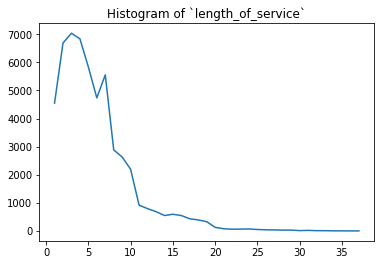

In [20]:
plt.plot(los_frequency)
plt.title('Histogram of `length_of_service`');

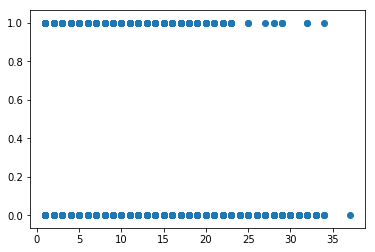

In [21]:
plt.scatter(data['length_of_service'], data['is_promoted'])

`length_of_service` does not appear to have a direct impact on `is_promoted`

#3. <u>Effect of `previous_year_rating`</u>

In [22]:
## We again apply a one-sample t-test to evaluate the effect of `previous_year_rating`
a = data.groupby('is_promoted')['previous_year_rating'].mean().to_frame()
from scipy.stats import ttest_ind
ttest_ind(a = data[data['is_promoted'] == 0]['previous_year_rating'], b = data[data['is_promoted'] == 1]['previous_year_rating'])

Ttest_indResult(statistic=-36.25465350548299, pvalue=1.9855663487740048e-284)

`previous_year_rating` is statistically significant.

### Classification Models
Let's now build a Logistic Regression model using `previous_year_rating` and `avg_training_score` to predict the probability of promotion. 

In [23]:
from sklearn.linear_model import LogisticRegression

Lets look at the distribution of our classes (`is_promoted` = 1 versus `is_promoted` = 0):

In [24]:
data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

We have an imbalanced dataset; with (`is_promoted` = 0) : (`is_promoted` = 1) ratio equal to ~ 10:1.

One way of dealing with the imbalance is to build a penalized Logistic Regression model, with the cost function accounting for a greater cost of misclassifying `is_promoted` = 1, since it is rarer in the dataset.

In [25]:
## 70% of our data is used for training, 30% is used for testing.
lr_data = data[['avg_training_score', 'previous_year_rating', 'is_promoted']]
lr_data_train = lr_data.sample(frac = 0.7)
lr_data_test = lr_data.loc[~data.index.isin(lr_data_train.index)]

In [26]:
lr_model1 = LogisticRegression(class_weight = {0:0.15, 1:0.85})
lr_model1_fit = lr_model1.fit(X = lr_data_train[['avg_training_score', 'previous_year_rating']], 
                              y = lr_data_train['is_promoted'])

Since this contest is evaluated on the basis of F1 score, we import the F1 metric from `sklearn.metrics`, which is the harmonic mean of precision and recall.

In [27]:
from sklearn.metrics import f1_score
y_true = lr_data_test['is_promoted']
y_pred = lr_model1_fit.predict(lr_data_test[['avg_training_score', 'previous_year_rating']])
print('F1_Score: ',f1_score(y_true = y_true, y_pred = y_pred))

F1_Score:  0.2971776425013835


In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[13365,  1667],
       [  873,   537]], dtype=int64)

Impact of `department` on `avg_training_score`:

It is reasonable to believe that different verticals would have different trainings, and that the difficulty levels would be different. For example, an `avg_training_score` of 80 in Sales&Marketing may be different from Finance, and the "cutoff" for promotion consideration may thus differ. Let's explore this:

In [29]:
dept_tscores = data.groupby('department')['avg_training_score'].agg({'mean' : 'mean', 'std_dev' : 'std'})
dept_tscores

C:\Users\Vishnu\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,mean,std_dev
department,,
Analytics,84.602952,2.855495
Finance,60.222003,4.929564
HR,50.018197,4.680137
Legal,59.868142,4.103776
Operations,60.226648,4.818071
Procurement,70.122443,4.305110
R&D,84.596597,2.921215
Sales & Marketing,50.261698,5.551414
Technology,79.928692,3.355511


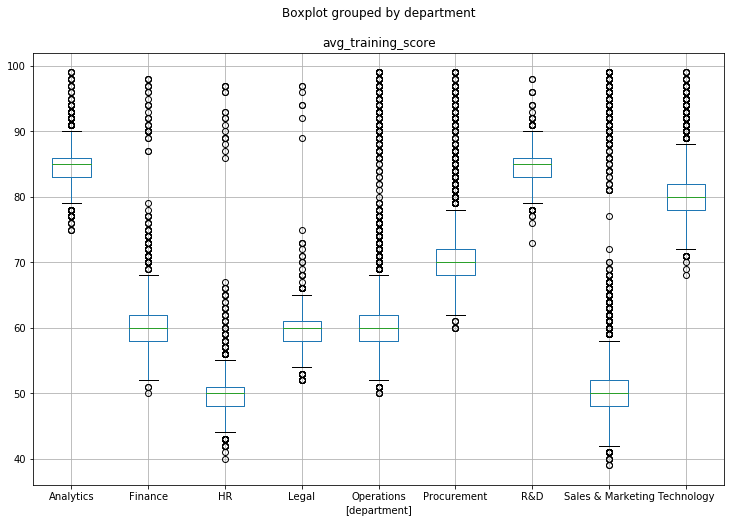

In [30]:
dept_tscores = data[['department', 'avg_training_score']]
dept_tscores.boxplot(column = ['avg_training_score'], by = ['department'], figsize = (12,8));

Visually, we see that <u>Analytics, R&D, Procurement, Technology</u> appear to have high `avg_training_score` values. We can feature a new binary variable that equals 1 if the employee belongs to any of these departments else 0. 



In [31]:
data['HS_Dept'] = np.where(data['department'].isin(['Analytics', 'R&D', 'Procurement', 'Technology']), 1, 0)
data.head(3)

,department,region,education,recruitment_channel,no_of_trainings,age,F,length_of_service,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,HS_Dept
employee_id,,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,sourcing,1,35,1,8,5.0,1,0,49,0,0
65141,Operations,region_22,Bachelor's,other,1,30,0,4,5.0,0,0,60,0,0
7513,Sales & Marketing,region_19,Bachelor's,sourcing,1,34,0,7,3.0,0,0,50,0,0


In [32]:
lr_data = data[['avg_training_score', 'previous_year_rating', 'HS_Dept', 'is_promoted']]
lr_data_train = lr_data.sample(frac = 0.7)
lr_data_test = lr_data.loc[~lr_data.index.isin(lr_data_train.index)]

In [33]:
lr_model2 = LogisticRegression(class_weight = {0:0.2, 1:0.8})
lr_model2_fit = lr_model2.fit(X = lr_data_train[['avg_training_score', 'previous_year_rating','HS_Dept']], 
                              y = lr_data_train['is_promoted'])

In [34]:
y_true = lr_data_test['is_promoted']
y_pred = lr_model2_fit.predict(lr_data_test[['avg_training_score', 'previous_year_rating', 'HS_Dept']])
print('F1_Score: ',f1_score(y_true = y_true, y_pred = y_pred))

F1_Score:  0.3412284223203533


In [35]:
confusion_matrix(y_true, y_pred)

array([[14376,   657],
       [  984,   425]], dtype=int64)

There is some improvement, but let's try to improve the feature we have. Let's look at the boxplot again:

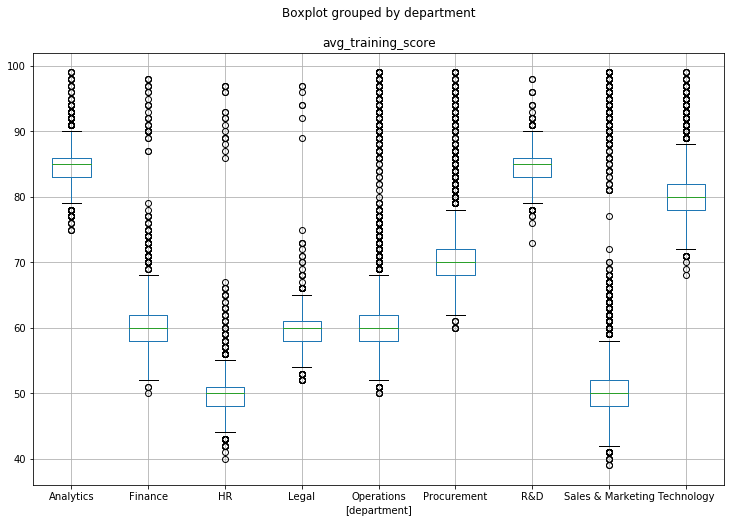

In [36]:
dept_tscores = data[['department', 'avg_training_score']]
dept_tscores.boxplot(column = ['avg_training_score'], by = ['department'], figsize = (12,8));

In [37]:
data['HS_Dept_G1'] = np.where(data['department'].isin(['Analytics', 'R&D', 'Technology']), 1, 0)
data['HS_Dept_G2'] = np.where(data['department'].isin(['Finance', 'Legal', 'Operations', 'Procurement']), 1, 0)

In [38]:
data.head()

,department,region,education,recruitment_channel,no_of_trainings,age,F,length_of_service,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,HS_Dept,HS_Dept_G1,HS_Dept_G2
employee_id,,,,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,sourcing,1,35,1,8,5.0,1,0,49,0,0,0,0
65141,Operations,region_22,Bachelor's,other,1,30,0,4,5.0,0,0,60,0,0,0,1
7513,Sales & Marketing,region_19,Bachelor's,sourcing,1,34,0,7,3.0,0,0,50,0,0,0,0
2542,Sales & Marketing,region_23,Bachelor's,other,2,39,0,10,1.0,0,0,50,0,0,0,0
48945,Technology,region_26,Bachelor's,other,1,45,0,2,3.0,0,0,73,0,1,1,0


In [39]:
lr_data = data[['avg_training_score', 'previous_year_rating', 'HS_Dept_G1', 'HS_Dept_G2', 'is_promoted']]
lr_data_train = lr_data.sample(frac = 0.7)
lr_data_test = lr_data.loc[~lr_data.index.isin(lr_data_train.index)]

In [40]:
lr_model3 = LogisticRegression(class_weight = {0:0.2, 1:0.8})
lr_model3_fit = lr_model3.fit(X = lr_data_train[['avg_training_score', 'previous_year_rating', 'HS_Dept_G1', 'HS_Dept_G2']], 
                              y = lr_data_train['is_promoted'])

In [41]:
y_true = lr_data_test['is_promoted']
y_pred = lr_model3_fit.predict(lr_data_test[['avg_training_score', 'previous_year_rating', 'HS_Dept_G1', 'HS_Dept_G2']])
print('F1_Score: ',f1_score(y_true = y_true, y_pred = y_pred))
confusion_matrix(y_true, y_pred)

F1_Score:  0.38966202783300197


array([[14417,   585],
       [  950,   490]], dtype=int64)

There is an improvement, but let's try to build a logistic regression by undersampling the majority class now.

Let's undersample the majority class to maintain a 2:1 ratio of `is_promoted` = 0 : `is_promoted` = 1 

In [42]:
lr_data = data[['previous_year_rating', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 
                'HS_Dept_G1', 'HS_Dept_G2', 'is_promoted']]

class1 = lr_data[lr_data['is_promoted'] == 1].sample(frac = 0.7).sample(frac = 3.5, replace = True)
class0 = lr_data[lr_data['is_promoted'] == 0].sample(frac = 0.3)

lr_data_train = class1.append(class0)

class1_test = data[(data['is_promoted'] == 1) & (~data.index.isin(class1.index))]
class0_test = data[(data['is_promoted'] == 0) & (~data.index.isin(class0.index))]

lr_data_test = class1_test.append(class0_test)

In [43]:
lr_data_train['is_promoted'].value_counts()

0    15042
1    11438
Name: is_promoted, dtype: int64

Seems relatively balanced now. Let's fit an unweighted logistic regression model now.

In [44]:
lr_model4 = LogisticRegression()
lr_model4_fit = lr_model4.fit(X = lr_data_train[['previous_year_rating', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 
                'HS_Dept_G1', 'HS_Dept_G2']],
                             y = lr_data_train['is_promoted'])
y_pred = lr_model4.predict(lr_data_test[['previous_year_rating', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 
                'HS_Dept_G1', 'HS_Dept_G2']])
y_true = lr_data_test['is_promoted']

In [45]:
f1_score(y_pred = y_pred, y_true = y_true)

0.20743639921722112

In [46]:
## Finding best set of variables:

lr_model4 = LogisticRegression()
lr_model4_fit = lr_model4.fit(X = lr_data_train[['previous_year_rating',  'avg_training_score']],
                             y = lr_data_train['is_promoted'])
y_pred = lr_model4.predict(lr_data_test[['previous_year_rating', 'avg_training_score']])
y_true = lr_data_test['is_promoted']
f1_score(y_pred = y_pred, y_true = y_true)

0.1443467222776317

In [47]:
confusion_matrix(y_pred = y_pred, y_true = y_true)

array([[26356,  8742],
       [  695,   796]], dtype=int64)

We're doing worse than before, so let's change strategies. Let's try Random Forests:

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
data.head(1)

,department,region,education,recruitment_channel,no_of_trainings,age,F,length_of_service,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,HS_Dept,HS_Dept_G1,HS_Dept_G2
employee_id,,,,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,sourcing,1,35,1,8,5.0,1,0,49,0,0,0,0


In [50]:
rfc_data = data[['previous_year_rating', 'KPIs_met >80%', 
                 'awards_won?', 'avg_training_score', 
                'HS_Dept_G1', 'HS_Dept_G2', 
                 'is_promoted']]
rfc_data.head(2)

,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,HS_Dept_G1,HS_Dept_G2,is_promoted
employee_id,,,,,,,
65438,5.0,1,0,49,0,0,0
65141,5.0,0,0,60,0,1,0


In [51]:
rfc_data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [87]:
rfc_data_train = rfc_data.sample(frac = 0.7)
rfc_data_test = rfc_data.loc[~rfc_data.index.isin(rfc_data_train.index)]

rfc_model1 = RandomForestClassifier(n_estimators = 500, max_features = 4)

cols = ['previous_year_rating', 'KPIs_met >80%', 'HS_Dept_G1', 'HS_Dept_G2','awards_won?', 'avg_training_score']

rfc_model1_fit = rfc_model1.fit(X = rfc_data_train[cols],
                                y = rfc_data_train['is_promoted'])

y_pred = rfc_model1_fit.predict(rfc_data_test[cols])
y_true = rfc_data_test['is_promoted']

Variable Importance plot:

In [88]:
imp = rfc_model1_fit.feature_importances_
pd.DataFrame({'features':cols, 'GINI_imp':imp}).sort_values(by = 'GINI_imp', ascending = False)

,features,GINI_imp
5,avg_training_score,0.543078
3,HS_Dept_G2,0.127766
1,KPIs_met >80%,0.111053
0,previous_year_rating,0.104773
4,awards_won?,0.066994
2,HS_Dept_G1,0.046336


In [89]:
print(f1_score(y_true = y_true, y_pred = y_pred))
confusion_matrix(y_pred = y_pred, y_true = y_true)

0.4488311688311688


array([[14949,    61],
       [ 1000,   432]], dtype=int64)

In [90]:
## Further splitting rfc_data_test into 3 dataframes:

rfc_data_test1 = rfc_data_test.sample(frac = 0.3, random_state = 19)
rfc_data_test2 = rfc_data_test[~rfc_data_test.index.isin(rfc_data_test1.index)].sample(frac = 0.3, random_state = 19)
rfc_data_test3 = rfc_data_test[(~rfc_data_test.index.isin(rfc_data_test1.index)) & (~rfc_data_test.index.isin(rfc_data_test2.index))]

In [91]:
len(rfc_data_test1) + len(rfc_data_test2) + len(rfc_data_test3) == len(rfc_data_test)

True

Now we have three test datasets, let's apply our model and make some predictions:

In [92]:
## Test-set 1
y_pred1 = rfc_model1_fit.predict(rfc_data_test1[['avg_training_score', 'previous_year_rating',
                                                'HS_Dept_G1', 'HS_Dept_G2',
                                      
                                   'KPIs_met >80%', 'awards_won?'
                                   ]])
y_true1 = rfc_data_test1['is_promoted']
print('Testset-1: ', f1_score(y_true = y_true1, y_pred = y_pred1))

## Test-set 2
y_pred2 = rfc_model1_fit.predict(rfc_data_test2[['avg_training_score', 'previous_year_rating',
                                              'HS_Dept_G1', 'HS_Dept_G2',
                                    
                                   'KPIs_met >80%', 'awards_won?'
                                   ]])
y_true2 = rfc_data_test2['is_promoted']
print('Testset-2: ',f1_score(y_true = y_true2, y_pred = y_pred2))

## Test-set 3
y_pred3 = rfc_model1_fit.predict(rfc_data_test3[['avg_training_score', 'previous_year_rating',
                                              'HS_Dept_G1', 'HS_Dept_G2',
                                  
                                   'KPIs_met >80%', 'awards_won?'
                                   ]])
y_true3 = rfc_data_test3['is_promoted']
print('Testset-3: ',f1_score(y_true = y_true3, y_pred = y_pred3))

Testset-1:  0.2827225130890052
Testset-2:  0.2724207687120701
Testset-3:  0.28610957387935804


We can improve the performance of RandomForestClassifier by tuning the parameters further:

In [94]:
from sklearn.model_selection import GridSearchCV

In [120]:
params = {
'class_weight' : [{0:0.1, 1:0.9}, {0:0.15, 1:0.85}, {0:0.2, 1:0.8}, 
                  {0:0.25, 1:0.75}, {0:0.3, 1:0.7}, {0:0.35, 1:0.65}]    
}

In [121]:
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, params, scoring = 'f1', return_train_score = True, cv = 4)

cols = ['avg_training_score', 'previous_year_rating', 'HS_Dept_G1', 'HS_Dept_G2','KPIs_met >80%', 'awards_won?']

gs_fit = clf.fit(X = data[cols],
       y = data['is_promoted'])

In [119]:
gs_fit.cv_results_

{'mean_fit_time': array([0.25968015, 0.26275754, 0.26538199, 0.26300961, 0.27020466,
        0.27790284]),
 'mean_score_time': array([0.0385623 , 0.03646213, 0.03954202, 0.03711867, 0.03655362,
        0.03670287]),
 'mean_test_score': array([0.3475699 , 0.38248472, 0.41940866, 0.43830892, 0.4452844 ,
        0.44024236]),
 'mean_train_score': array([0.38161628, 0.44352467, 0.49353836, 0.50289684, 0.49844425,
        0.489868  ]),
 'param_class_weight': masked_array(data=[{0: 0.1, 1: 0.9}, {0: 0.15, 1: 0.85}, {0: 0.2, 1: 0.8},
                    {0: 0.25, 1: 0.75}, {0: 0.3, 1: 0.7},
                    {0: 0.35, 1: 0.6}],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'class_weight': {0: 0.1, 1: 0.9}},
  {'class_weight': {0: 0.15, 1: 0.85}},
  {'class_weight': {0: 0.2, 1: 0.8}},
  {'class_weight': {0: 0.25, 1: 0.75}},
  {'class_weight': {0: 0.3, 1: 0.7}},
  {'class_weight': {0: 0.35, 1: 0.6}}],
 'rank_tes

## SUBMISSION CODE

In [57]:
testdata = pd.read_csv(r'C:\Hackathons\AV_WNS\test_2umaH9m.csv')

testdata['HS_Dept_G1'] = np.where(testdata['department'].isin(['Analytics', 'R&D', 'Technology']), 1, 0)
testdata['HS_Dept_G2'] = np.where(testdata['department'].isin(['Finance', 'Legal', 'Operations', 'Procurement']), 1, 0)

testdept_groups = testdata.groupby('department')['previous_year_rating'].mean().to_frame()
testdata = testdata.merge(testdept_groups, left_on = 'department', right_on = testdept_groups.index, how = 'left')
testdata['previous_year_rating'] = np.where(testdata['previous_year_rating_x'].isnull(), testdata['previous_year_rating_y'], testdata['previous_year_rating_x'])

In [58]:
testdata = testdata[['employee_id', 'avg_training_score', 'KPIs_met >80%', 'awards_won?',
                   'previous_year_rating', 'HS_Dept_G1', 'HS_Dept_G2']]
testdata.head()

,employee_id,avg_training_score,KPIs_met >80%,awards_won?,previous_year_rating,HS_Dept_G1,HS_Dept_G2
0,8724,77,1,0,3.151844,1,0
1,74430,51,0,0,3.000000,0,0
2,72255,47,0,0,1.000000,0,0
3,38562,65,0,0,2.000000,0,1
4,64486,61,0,0,4.000000,0,1


In [59]:
y_test_pred = rfc_model1_fit.predict(testdata[['avg_training_score', 'KPIs_met >80%', 
                                               'HS_Dept_G1', 'HS_Dept_G2',
                                               'awards_won?','previous_year_rating' 
                                               ]])

In [60]:
preds = pd.DataFrame(index = testdata['employee_id'], columns = ['is_promoted'])
preds['is_promoted'] = y_test_pred

In [61]:
preds.to_csv('WNS_preds_rfc_model2.csv')

In [62]:
sum(preds['is_promoted'])

2073